## Описание задачи

Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. <br> 
Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются <br>
от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить. Вам поставлена задача создать такую модель.

In [39]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import category_encoders as ce
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import re
import os

sns.set_theme(style="darkgrid")

path = os.path.dirname(os.getcwd()).replace('\\', '/') + '/'


import warnings
warnings.simplefilter("ignore", UserWarning)

warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)

In [40]:
df_train = pd.read_csv(path+'data_set/hotels_train.csv') 
df_test = pd.read_csv(path+'data_set/hotels_test.csv') 
sample_submission = pd.read_csv(path+'data_set/submission.csv') 

In [41]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels_data = pd.concat([df_train, df_test], sort=False, ignore_index=True)#.reset_index(drop=True) # объединяем

In [42]:
 
hotels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## Описание признаков

* **hotel_address** — адрес отеля; <br>

* **review_date** — дата, когда рецензент разместил соответствующий отзыв;
* **average_score** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* **hotel_name** — название отеля;
* **reviewer_nationality** — страна рецензента;
* **negative_review** — отрицательный отзыв, который рецензент дал отелю;
* **review_total_negative_word_counts** — общее количество слов в отрицательном отзыв;
* **positive_review** — положительный отзыв, который рецензент дал отелю;
* **review_total_positive_word_counts** — общее количество слов в положительном отзыве.
* **reviewer_score** — оценка, которую рецензент поставил отелю на основе своего опыта;
* **total_number_of_reviews_reviewer_has_given** — количество отзывов, которые рецензенты дали в прошлом;
* **total_number_of_reviews** — общее количество действительных отзывов об отеле;
* **tags** — теги, которые рецензент дал отелю;
* **days_since_review** — количество дней между датой проверки и датой очистки;
* **additional_number_of_scoring** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв.<br> Это число указывает, сколько там действительных оценок без проверки.
* **lat** — географическая широта отеля;
* **lng** — географическая долгота отеля.

# Кодирование категориальных признаков


## Кодирование страны, в которой расположен отель

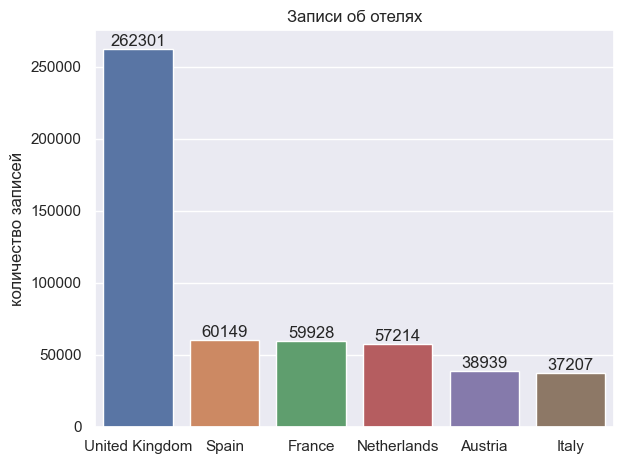

In [43]:
# Записываем категориальные признаки в отдельный датафрейм
obj_data_hotel = hotels_data[['hotel_address', 'hotel_name', 
                            'reviewer_nationality', 'negative_review', 
                            'positive_review', 'tags']]


# Из признака 'hotel_address' мы можем извлечь название страны
obj_data_hotel['hotel_country'] = \
    obj_data_hotel['hotel_address'].apply(lambda x: x.split(' ')[-2:]) 
    
    
    
obj_data_hotel['hotel_country'] = \
    obj_data_hotel['hotel_country'].apply(lambda x: x[1] if x[0] != 'United' and \
        x[1] != 'Kingdom' else 'United Kingdom')
    
# Судя по всему в датафрейме указаны только столичные отели, поэтому 
# извлекать название города в отдельную переменную нет необходимости    
    
    
# Подсчитываем количество записей об отелях по странам и выводим ввиде барплота
hotel_cntry_count = obj_data_hotel['hotel_country'].value_counts().to_frame()

hotel_cntry_count.reset_index().rename(columns={'hotel_country':'hotel_country'})

hotel_cntry_bar = sns.barplot(data=hotel_cntry_count, x='hotel_country', 
                             y='count', hue='hotel_country', palette='deep',
                             errorbar=None)

hotel_cntry_bar.set(title='Записи об отелях', 
                   ylabel='количество записей', xlabel='')


for i in hotel_cntry_bar.containers:
    hotel_cntry_bar.bar_label(i)
    
plt.tight_layout()


Наибольшее количество комментариев наблюдается в Велиобритании

## Кодирование признаков, отражающих <br> названия отеля и национальности рецензента

In [44]:
# Оцениваем количество уникальных значений в признаке 'hotel_name'
print(f"Количество уникальных значений \
hotel_name {obj_data_hotel['hotel_name'].nunique()}")

print(f"Количество уникальных значений \
reviewer_nationality {obj_data_hotel['reviewer_nationality'].nunique()}")


# Кодируем эту переменную с помощью Binary Encoder 
# так как уникальных значений значительно выше 15
bin_encoder = ce.BinaryEncoder(cols=['hotel_name'])
bin_hotlname = bin_encoder.fit_transform(obj_data_hotel['hotel_name'])
bin_hotlname


# Аналогичным образом можно закодировать 'reviewer_nationality'
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
bin_new_nation = bin_encoder.fit_transform(obj_data_hotel['reviewer_nationality'])
bin_new_nation

Количество уникальных значений hotel_name 1492
Количество уникальных значений reviewer_nationality 227


,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...
515733,0,0,1,1,1,0,1,0
515734,0,0,0,0,1,1,0,0
515735,0,0,1,0,0,1,1,1
515736,0,0,1,0,0,1,0,0


## Кодирование негативных и позитиных комментариев

### Negative review

In [45]:
# Приводим все строки в переменной 'negative_review' к нижнему регистру
obj_data_hotel['negative_review'] = \
    obj_data_hotel['negative_review'].apply(lambda x: x.lower())

# Выбираем топ 150 коментариев, среди которых ложно-отрицательные
# (по типу "No negative" или "nothing") будут всречаться наиболее часто
non_neg_lst = obj_data_hotel['negative_review'].value_counts()\
    .nlargest(150).to_frame().reset_index()



# Среди этого топа комментариев выбираем ключевые слова, которые ассоциированы
# с истинно-отрицательными комментариями по типу "bad wifi" 
to_find = r'nois|room|leav|pric|bed|cost|applicable|parking|gym|^.*wifi$|staff|\
    |breakfast|bathroom|everything|pool|bar|view|service|location|expensive|\
        |cleanliness|weather|pillows'

# Функция возвращает None если слово в списке to_find, 
# в противном случае возвращает строку без изменений
def FindRegEx (string):
    findlst = re.findall(to_find, string)
    if len(findlst) > 0:
        return
    else:
        return string


non_neg_lst['negative_review'] = \
    non_neg_lst['negative_review'].apply(lambda x: ''.join(x.split(' ')))

non_neg_lst['negative_review'] = \
    non_neg_lst['negative_review'].apply(FindRegEx)
    
    
# Удаляем None и оставляем только уникальные значения
non_neg_lst.dropna(inplace=True)
non_neg_lst = list(set(non_neg_lst['negative_review']))



# Удаляем пробеды из признака 'negative_review'
obj_data_hotel['negative_review'] = \
    obj_data_hotel['negative_review'].apply(lambda x: ''.join(x.split(' ')))
    

# Заменяем ложно-негативные на 0, истинно негативные на 1
obj_data_hotel['negative_review'] = \
    obj_data_hotel['negative_review'].apply(lambda x: 0 if x in non_neg_lst or x.startswith('nothing')  else 1)
    
neg_rew_mod = obj_data_hotel['negative_review'].to_frame()

### Positive review

In [46]:
# Аналогичны образом можно модифицировать признак 'positive_review'

# Приводим все строки в переменной 'negative_review' к нижнему регистру
obj_data_hotel['positive_review'] = \
    obj_data_hotel['positive_review'].apply(lambda x: x.lower())

# Выбираем топ 150 коментариев, среди которых ложно-отрицательные
# (по типу "No negative" или "nothing") будут всречаться наиболее часто
non_pos_lst = obj_data_hotel['positive_review'].value_counts()\
    .nlargest(150).to_frame().reset_index()
    


# Среди этого топа комментариев выбираем ключевые слова, которые ассоциированы
# с ложно-положительными комментариями по типу "nothing" 
to_find = r'^na|^no'


# Функция возвращает строку если слово в списке to_find, 
# в противном случае возвращает None
def FindRegEx (string):
    findlst = re.findall(to_find, string)
    if len(findlst) > 0 or string == '':
        return string
    else:
        return 
    
    
non_pos_lst['positive_review'] = \
    non_pos_lst['positive_review'].apply(lambda x: ''.join(x.split(' ')))

non_pos_lst['positive_review'] = \
    non_pos_lst['positive_review'].apply(FindRegEx)
    
    
# Удаляем None и оставляем только уникальные значения
non_pos_lst.dropna(inplace=True)
non_pos_lst = list(set(non_pos_lst['positive_review']))



# Удаляем пробеды из признака 'positive_review'
obj_data_hotel['positive_review'] = \
    obj_data_hotel['positive_review'].apply(lambda x: ''.join(x.split(' ')))
    

# Заменяем ложно-негативные на 0, истинно негативные на 1
obj_data_hotel['positive_review'] = \
    obj_data_hotel['positive_review'].apply(lambda x: 0 if x in non_pos_lst else 1)
    
pos_rew_mod = obj_data_hotel['positive_review'].to_frame()

### Выводим результат в виде барплотов

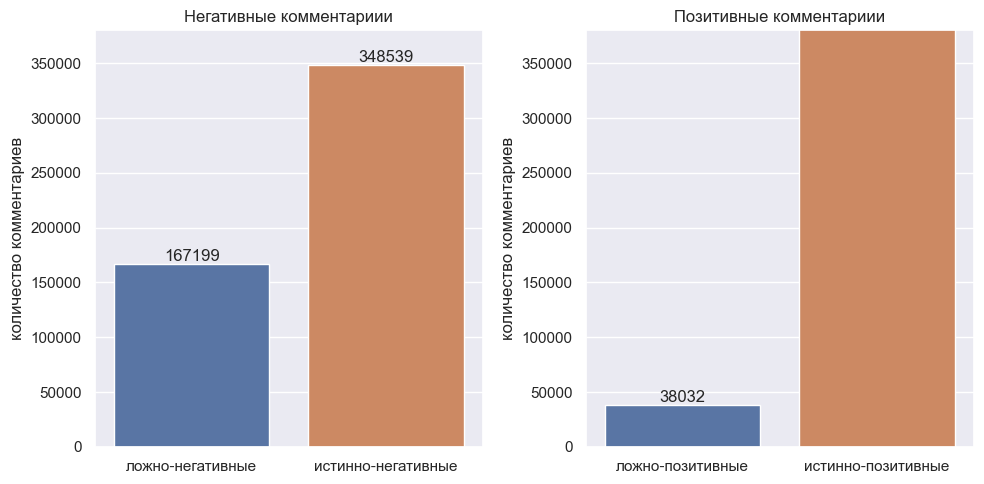

In [47]:
# Выводим в виде барплотов
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
 
    
# Барплот с негативными комментариями   
neg_com_count = obj_data_hotel['negative_review'].value_counts().to_frame()
neg_com_count.reset_index()
neg_com_count_bar = sns.barplot(data=neg_com_count, x='negative_review', ax=ax[0],
                             y='count', hue='negative_review', palette='deep',
                             errorbar=None, legend=False)

neg_com_count_bar.set(title='Негативные комментариии', 
                   ylabel='количество комментариев', xlabel='',
                   xticklabels=['ложно-негативные', 'истинно-негативные'],
                   ylim=(0, 380000))


for i in neg_com_count_bar.containers:
    neg_com_count_bar.bar_label(i)
################################################################################    


# Барплот с позитивными комментариями
pos_com_count = obj_data_hotel['positive_review'].value_counts().to_frame()
pos_com_count.reset_index()
pos_com_count_bar = sns.barplot(data=pos_com_count, x='positive_review', ax=ax[1],
                             y='count', hue='positive_review', palette='deep',
                             errorbar=None, legend=False)

pos_com_count_bar.set(title='Позитивные комментариии', 
                   ylabel='количество комментариев', xlabel='',
                   xticklabels=['ложно-позитивные', 'истинно-позитивные'],
                   ylim=(0, 380000))

for i in pos_com_count_bar.containers:
    pos_com_count_bar.bar_label(i)
################################################################################   



fig.tight_layout()

## Извлекаем дополнительные признаки из признака 'tags'

In [48]:
tag_data = obj_data_hotel['tags'].to_frame()

# Превращаем строки в списки
tag_data['tags'] = \
    tag_data['tags'].apply(lambda x: re.sub(r"[\[\] ']", '', x).lower().split(','))


# Создаем признаки которые отражают тип поездки
tag_data['leisure_trip'] = \
    tag_data['tags'].apply(lambda x: 1 if 'leisuretrip' in x else 0)
    
tag_data['business_trip'] = \
    tag_data['tags'].apply(lambda x: 1 if 'businesstrip' in x else 0)


# Способ бронирования
tag_data['mobile_submit'] = \
    tag_data['tags'].apply(lambda x: 1 if 'submittedfromamobiledevice' in x else 0)


# Количества постояльцев 
tag_data['solo_traveler'] = \
    tag_data['tags'].apply(lambda x: 1 if 'solotraveler' in x else 0)
    
tag_data['couple'] = \
    tag_data['tags'].apply(lambda x: 1 if 'couple' in x else 0)
    
tag_data['group'] = \
    tag_data['tags'].apply(lambda x: 1 if 'group' in x else 0)


# С детьми 
tag_data['family_with_young_children'] =\
    tag_data['tags'].apply(lambda x: 1 if 'familywithyoungchildren' in x else 0)
    
tag_data['family_with_older_children'] =\
    tag_data['tags'].apply(lambda x: 1 if 'familywitholderchildren' in x else 0)


# Количество ночей
tag_data['NightsCnt'] = \
    tag_data['tags'].apply(lambda x: x[-1] if x[-1].startswith('stayed') else 0)

# В получившемся признаке оставляем только цифры 
tag_data['NightsCnt'] = \
    tag_data['NightsCnt'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]))


## Кодируем признаки, извлеченные из tags

In [49]:
# Функция удаляет все теги из 'tags'
def tag_remover(tag_lst):
    
    tag_to_remove = ['leisuretrip', 'businesstrip', 'submittedfromamobiledevice', 
                     'solotraveler', 'couple', 'group', 'familywithyoungchildren', 
                     'familywitholderchildren']
    
    # В tag_lst остается только те теги которого нету в списке tag_to_remove
    tag_lst = [i for i in tag_lst if i not in tag_to_remove]
    
    # Оставляем только те теги которые не соответсвуют regex
    regex = re.compile(r'^stayed.*$') 
    tag_lst = [j for j in tag_lst if not regex.match(j)] 
    
    # Возвращаем None если tag_lst пустой, иначе возвращаем 1-ый элемент
    return None if len(tag_lst) < 1 else tag_lst[0]
################################################################################


# Применяем функцию к списку тегов
tag_data['tags'] = tag_data['tags'].apply(tag_remover)

# Заполняем None модальным значением
tag_data['tags'] = tag_data['tags'].fillna(tag_data['tags'].mode()[0])

# Переименовываем 'tags' в 'room_type'
tag_data = tag_data.rename(columns={'tags':'room_type'})



# Кодируем 'room_type' с помощью BinaryEncoder из-за большого числа уникальных значений
bin_encoder = ce.BinaryEncoder(cols='room_type')

tag_bin = bin_encoder.fit_transform(tag_data['room_type'])
tag_data = pd.concat([tag_data, tag_bin], axis=1)


# Удаляем 'room_type' из tag_data
tag_data_encoded = tag_data.drop('room_type', axis=1)

## Обединяем все получнные данные в единый датафрейм

In [50]:
# Обединяем все в один финальный датафрейм с закодированными переменными
obj_htl_encoded = pd.concat([obj_data_hotel,
                            tag_data_encoded,
                            bin_hotlname,
                            bin_new_nation], axis=1)
# Удаляем ненужные столбцы
obj_htl_encoded =\
    obj_htl_encoded.drop(['hotel_address', 'hotel_name',
                                'reviewer_nationality',
                               'tags', 'hotel_country'], axis=1)
    
obj_htl_encoded

,negative_review,positive_review,leisure_trip,business_trip,mobile_submit,solo_traveler,couple,group,family_with_young_children,family_with_older_children,...,hotel_name_9,hotel_name_10,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,1,1,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1,1,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,1,0,1,0,1,1,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,0,1,0,1,0,0,1,0,0,0,...,1,0,0,0,1,1,1,0,1,0
515734,0,1,1,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1,1,0,0
515735,1,1,0,1,0,1,0,0,0,0,...,1,0,0,0,1,0,0,1,1,1
515736,0,1,1,0,1,1,0,0,0,0,...,1,1,0,0,1,0,0,1,0,0


## Определяем какие категориальные  признаки наиболее важны в определении рейтинга отеля

In [51]:
country_dummies = pd.get_dummies(obj_data_hotel['hotel_country'], dtype=int)

obj_htl_encoded = pd.concat([obj_htl_encoded, country_dummies], axis=1)
obj_htl_encoded

,negative_review,positive_review,leisure_trip,business_trip,mobile_submit,solo_traveler,couple,group,family_with_young_children,family_with_older_children,...,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,Austria,France,Italy,Netherlands,Spain,United Kingdom
0,1,1,1,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,1,1,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1,0,1,0,1,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1,1,0,1,0,0,1,0,0,0,...,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,0,1,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
515734,0,1,1,0,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,1,0
515735,1,1,0,1,0,1,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
515736,0,1,1,0,1,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


,negative_review,business_trip,NightsCnt,positive_review,solo_traveler,reviewer_nationality_6,reviewer_nationality_3,leisure_trip,couple,mobile_submit,reviewer_nationality_2,United Kingdom,Spain,Austria,room_type_5
0,1,0,0,1,0,0,0,1,1,1,0,1,0,0,0
1,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0
2,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0
3,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0
4,1,1,6,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,0,1,4,1,0,1,1,0,1,0,1,0,0,0,0
515734,0,0,0,1,0,0,0,1,1,1,0,0,1,0,0
515735,1,1,2,1,1,1,0,0,0,0,1,0,0,1,0
515736,0,0,0,1,1,0,0,1,0,1,1,0,0,0,0


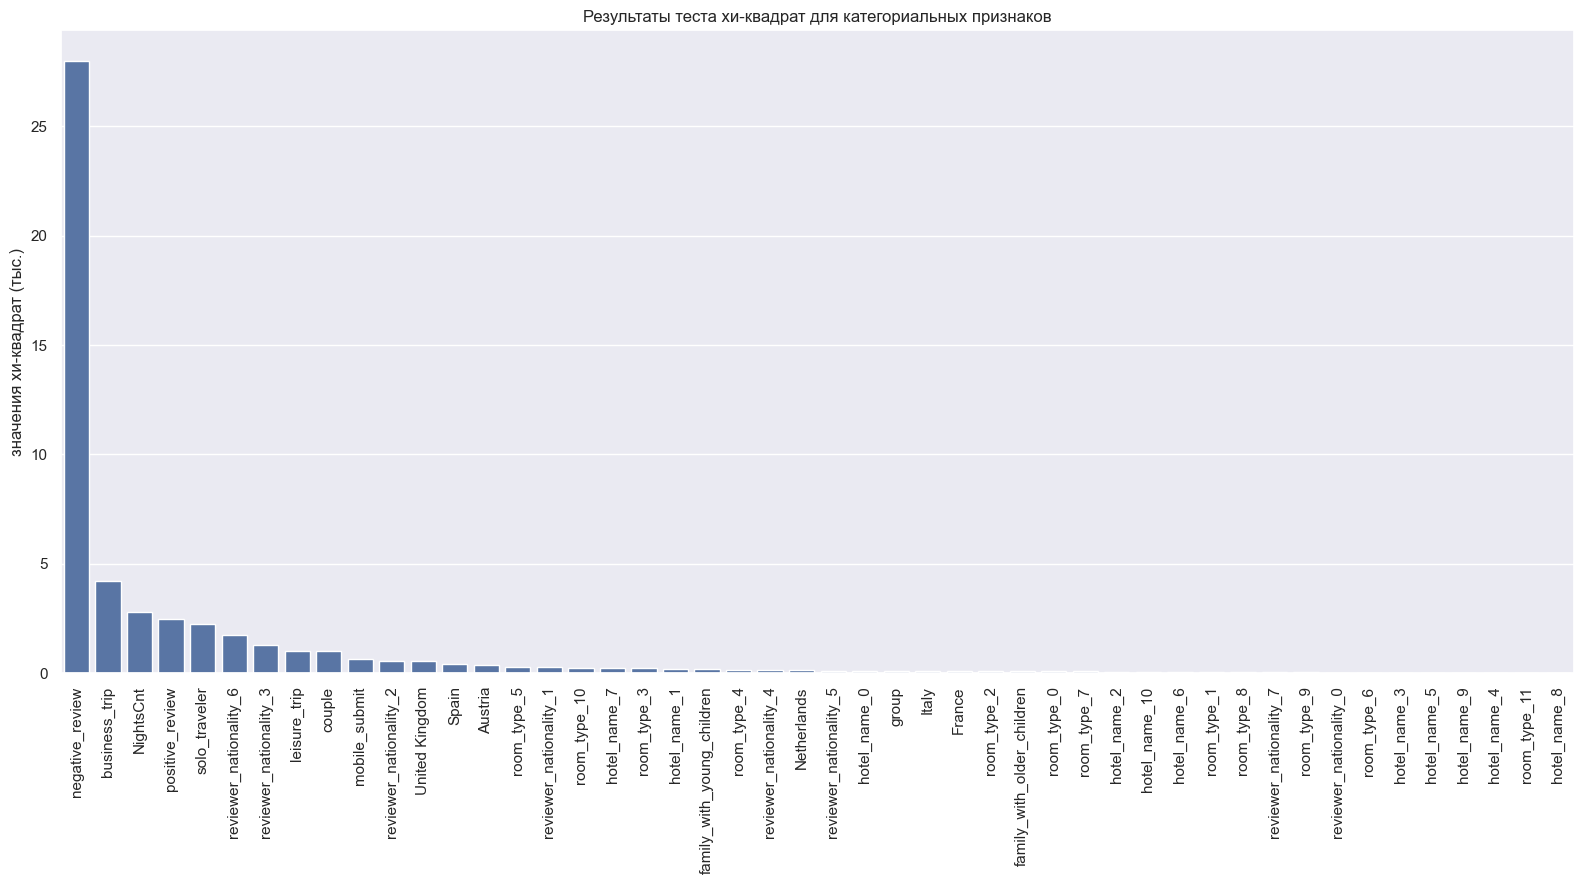

In [52]:
from sklearn.feature_selection import chi2 # хи-квадрат


# В у записываем определяемую пременную
y = hotels_data['reviewer_score'].astype('int')


# Оцениваем взаимосвязь с помощью критерия хи-квадрат
imp_cat = pd.Series(chi2(obj_htl_encoded, y)[0], 
                    index=list(obj_htl_encoded))

imp_cat.sort_values(ascending=False, inplace = True)

# Отображаем в виде барплота
fig, ax = plt.subplots( figsize=(16, 9))

BarPl = sns.barplot(x=imp_cat.index, 
                    y=imp_cat.values/1000, 
                    ax=ax)

BarPl.set(title='Результаты теста хи-квадрат для категориальных признаков',
          xlabel='', ylabel='значения хи-квадрат (тыс.)' )

plt.xticks(rotation=90)

fig.tight_layout()
fig.show()


# Выбираем топ 15 признаков
CatLst = imp_cat.nlargest(15).index.tolist()

obj_data_hotel_final = obj_htl_encoded[CatLst]
obj_data_hotel_final

# Преобразование числовых переменных

## Кодируем признак широты (lat) и долготы (lng)

In [53]:
# Создаем сабсет данных в котором адресс, название отеля, широта и долгота
lng_lat_adress = hotels_data[['hotel_address', 'hotel_name', 'lat', 'lng']]


# Выбираем те отели у которых широта и долгота не указана
nan_adress = lng_lat_adress.value_counts(dropna=False).to_frame().reset_index()
nan_adress = nan_adress[nan_adress.isna().any(axis=1)]

# Удаляем столбцы lft и lng
nan_adress.drop(['lat', 'lng'],axis=1,  inplace=True)


# Находим в интернете широту и долготу отеля в соотвествии с названием и адресом 

lat_list = pd.Series([48.2096504, 48.2142545895604, 48.22120185675868,
                      48.87551837965355, 48.188943519187056, 48.21699258761666,
                      48.21972663537052, 41.391692850593245, 48.246126541393814,
                      48.220994835060345, 48.88902204206753, 48.23374291809081,
                      48.2098277119672, 48.222882185965936, 48.84007089476592,
                      41.497753325197166, 41.392869991578905], index=nan_adress.index,  name='lat')


lng_list = pd.Series([16.3531596, 16.3969514861397, 16.354569268075707, 
                      2.323414455616681, 16.383843670936997, 16.359959342102087,
                      16.28562428443066, 2.1778725400405876, 16.341265226759894, 
                      16.36663295559496, 2.3331744556170846, 16.345713373670957,
                      16.35151694210201, 16.393444382580146, 2.3236462277344088,
                      2.1493629683693665, 2.167376140040634], index=nan_adress.index, name='lng')


# Добавляем значения lat и lng к нашему списку адресов
nan_adress = pd.concat([nan_adress, lat_list, lng_list], axis=1)


# Оставляем только название отеля и значение lat и lng
nan_adress = nan_adress[['hotel_name', 'lat', 'lng']]


# Соединяем оригинальный датафрейм со списком адресов с помощью pd.merge
lng_lat_adress = pd.merge(lng_lat_adress, nan_adress, how='left', on='hotel_name')
lng_lat_adress['lat_x'] = lng_lat_adress['lat_x'].fillna(lng_lat_adress['lat_y'])
lng_lat_adress['lng_x'] = lng_lat_adress['lng_x'].fillna(lng_lat_adress['lng_y'])


# Удаляем вспомогательные колонки 'lat_y', 'lng_y'
lng_lat_adress.drop(['lat_y', 'lng_y'], axis=1, inplace=True)
lng_lat_adress.rename(columns={'lat_x': 'lat', 'lng_x': 'lng'}, inplace=True)

# В дальнейшем из этого датафрейма нам потребуются только значения шроты и долготы 
# так что оставляем только эти столбцы
lng_lat_adress = lng_lat_adress[['lat', 'lng']]
lng_lat_adress

,lat,lng
0,51.507894,-0.143671
1,51.521009,-0.123097
2,48.845377,2.325643
3,48.888697,2.394540
4,52.385601,4.847060
...,...,...
515733,45.502453,9.221836
515734,41.378169,2.178663
515735,48.193523,16.366915
515736,45.468236,9.207380


## Извлекаем данные из признака даты

In [54]:

# Извлекаем информацию из даты
date_of_review = pd.to_datetime(hotels_data['review_date']).to_frame()

# День года
date_of_review['day_of_year'] = date_of_review['review_date'].dt.day_of_year

# Месяц года
date_of_review['month'] = date_of_review['review_date'].dt.month

# Квартал
date_of_review['quarter'] = date_of_review['review_date'].dt.quarter

# День недели
date_of_review['weekday'] = date_of_review['review_date'].dt.weekday

# Год
date_of_review['year'] = date_of_review['review_date'].dt.year


# Удаляем признак 'review_date'
date_of_review = date_of_review.drop('review_date', axis=1)

## Модифицируем признак review_total_negative_word_counts

Теперь, если мы внимательно посморим на признак 'review_total_negative_word_counts', то мы увидим, что только ложно-отрицательному словосочетанию 'No negative' соответсвует значение 0. <br>
Количество слов в истинно негативных комментариях также, зачастую не соответсвует действительности. Например, словосочетанию 'poor breakfast' соответсвует значение 3.<br>



In [55]:
neg_word_cnt = hotels_data.review_total_negative_word_counts.to_frame()
neg_word_cnt = pd.concat([hotels_data['negative_review'], neg_word_cnt], axis=1)


# На первом этапе разделяем убираем из строк пробелы в начале и в конце 
neg_word_cnt['negative_review'] = \
    neg_word_cnt['negative_review'].apply(lambda x: x[1:] if x.startswith(' ') else x) 
neg_word_cnt['negative_review'] = \
    neg_word_cnt['negative_review'].apply(lambda x: 'None' if x == '' else x) 
neg_word_cnt['negative_review'] = \
    neg_word_cnt['negative_review'].apply(lambda x: x[:-1] if x[-1] == ' ' else x) 


# Затем подсчитываем количество слов в строке уже без лишних проблов
neg_word_cnt['negative_review'] = \
    neg_word_cnt['negative_review'].apply(lambda x: x.split(' ')) 
neg_word_cnt['review_total_negative_word_counts'] = \
    neg_word_cnt['negative_review'].apply(len)

# Убираем оригинальный столбец 'negative_review' из датафрейма hotels_data и 
# добавляем модифицированный 'negative_review' из ObjDataHotel
neg_word_cnt.drop(['negative_review'], axis=1, inplace=True)
neg_word_cnt = pd.concat([obj_data_hotel['negative_review'], neg_word_cnt], axis=1)



# В столюце 'review_total_negative_word_counts' заменяем на ноль значения, 
# соответствующие ложно-негативным комментариям
neg_word_cnt['review_total_negative_word_counts'] =\
    neg_word_cnt.apply(lambda x: x['review_total_negative_word_counts'] \
        if x['negative_review'] == 1 else 0, axis=1)
    
# Оставляем только столбец эreview_total_negative_word_counts
neg_word_cnt.drop(['negative_review'], axis=1, inplace=True)
neg_word_cnt.head(10)

,review_total_negative_word_counts
0,1
1,2
2,4
3,0
4,2
5,0
6,0
7,38
8,29
9,45


# Выделяем столбцы с числовыми переменными в отдельный датафрейм


In [56]:
# Выделяем столбцы с числовыми переменными в отдельный датафрейм
num_data_hotel = hotels_data.drop(['hotel_address', 'hotel_name', 'lat', 'lng', 
                                 'review_total_negative_word_counts', 
                            'reviewer_nationality', 'negative_review', 'review_date',
                            'positive_review', 'tags'], axis=1)

num_data_hotel['days_since_review'] =\
    num_data_hotel['days_since_review'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

num_data_hotel = pd.concat([neg_word_cnt, num_data_hotel, lng_lat_adress, date_of_review], axis=1)
num_data_hotel

,review_total_negative_word_counts,additional_number_of_scoring,average_score,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,sample,lat,lng,day_of_year,month,quarter,weekday,year
0,1,581,8.4,1994,4,7,10.0,531,1,51.507894,-0.143671,50,2,1,4,2016
1,2,299,8.3,1361,2,14,6.3,203,1,51.521009,-0.123097,12,1,1,3,2017
2,4,32,8.9,406,0,14,7.5,289,1,48.845377,2.325643,292,10,4,1,2016
3,0,34,7.5,607,11,8,10.0,681,1,48.888697,2.394540,265,9,3,1,2015
4,2,914,8.5,7586,20,10,9.6,516,1,52.385601,4.847060,65,3,1,5,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,0,53,8.1,984,4,14,0.0,547,0,45.502453,9.221836,34,2,1,2,2016
515734,0,46,7.8,523,24,1,0.0,411,0,41.378169,2.178663,170,6,2,5,2016
515735,29,260,8.0,3461,23,1,0.0,28,0,48.193523,16.366915,187,7,3,3,2017
515736,0,159,9.0,1053,20,7,0.0,586,0,45.468236,9.207380,360,12,4,5,2015


## Модифицируем числовые переменные с помощью RobustScaler/StandartScaler

Для оценки на нормальность используем тест Колмогорова-Смирнова так как выборка значительно выше 5000 обрацов

In [57]:
def scaler(data_frame, feature, alpha=0.05):
    """ Функция на вход принимает признак и возвращает его либо
    нормализованный, либо стандартизованный вариант. Если распредленеие
    признака нормальное применяется стандартизация с помощью StandartScaler.
    Если распределение не нормальное, то применяется нормальзация с 
    использованием RobustScaler. Оценка нормальности осуществляется с помощью 
    теста Колмогорова-Смирнова 
    
    Args:
        data_frame (pd.DataFrame): датафрейм из которого берется признак
        feature (str): признак, который будет приобразован
        alpha (float, optional): пороговый уровень alpha относительно готорого 
                                 мы оцениваем нормальность распределения. 
                                 Defaults to 0.05.

    Returns:
        pd.Series: Возвращает преобразованный признак в формате pd.Series
    """
    
    # Проверяем признак на нормальность распределения
    kol_smrnf_p = stats.kstest(data_frame[feature], 'norm', 
                             args=(data_frame[feature].mean(), 
                                   data_frame[feature].std())).pvalue
    
    # Если распределение не нормальное преобразуем данные по методу yeo-johnson
    # затем применяем применяем RobustScaler
    if kol_smrnf_p < alpha:
        print(f'|| Признак {feature} || P-value теста Колмогорова-Смирнова < {alpha} || Применяю RobustScaler')
        print()
        
        
        pt_yeo_johnson = PowerTransformer(method='yeo-johnson')
        robust_sclr = RobustScaler()
        
        data_mod = pt_yeo_johnson.fit_transform(data_frame[feature].to_frame())
        data_mod = robust_sclr.fit_transform(data_frame[feature].to_frame())
        
        # преобразуем выдачу RobustScaler в pd.Series
        data_mod = [i[0] for i in data_mod]
        data_mod = pd.Series(data_mod, name=feature)
       
        
        # Возвращаем модифицированный признак
        return data_mod
    
    
    # Если распределение нормальное применяем StandardScaler
    else: 
        print(f'|| Признак {feature} || P-value теста Колмогорова-Смирнова > {alpha} || Применяю StandardScaler')
        print()
        
        standard_sclr = StandardScaler()
        data_mod = v.fit_transform(data_frame[feature].to_frame())
        
        # преобразуем выдачу RobustScaler в pd.Series
        data_mod = [i[0] for i in data_mod]
        data_mod = pd.Series(data_mod, name=feature)
        
        # Возвращаем модифицированный признак
        return data_mod

In [58]:
# С помощью функции scaler преобразуем признаки и записваем их в формате pd.Series 
# 'total_number_of_reviews 
num_data_hotel['total_number_of_reviews'] = scaler(data_frame=num_data_hotel,
                 feature='total_number_of_reviews')


# 'review_total_positive_word_counts
num_data_hotel['review_total_positive_word_counts'] = scaler(data_frame=num_data_hotel,
                 feature='review_total_positive_word_counts')

# 'review_total_negative_word_counts
num_data_hotel['review_total_negative_word_counts'] = scaler(data_frame=num_data_hotel,
                 feature='review_total_negative_word_counts')    
    
#'total_number_of_reviews_reviewer_has_given
num_data_hotel['total_number_of_reviews_reviewer_has_given'] = scaler(data_frame=num_data_hotel,
                 feature='total_number_of_reviews_reviewer_has_given')

# 'average_score'
num_data_hotel['average_score'] = scaler(data_frame=num_data_hotel,
                 feature='average_score')

# 'additional_number_of_scoring'
num_data_hotel['additional_number_of_scoring'] = scaler(data_frame=num_data_hotel,
                 feature='additional_number_of_scoring')

# 'days_since_review
num_data_hotel['days_since_review'] = scaler(data_frame=num_data_hotel,                
                 feature='days_since_review')
# lat
num_data_hotel['lat'] = scaler(data_frame=num_data_hotel,               
                 feature='lat')
# lng
num_data_hotel['lng'] = scaler(data_frame=num_data_hotel,
                
                 feature='lng')
# day_of_year
num_data_hotel['day_of_year'] = scaler(data_frame=num_data_hotel,
                 feature='day_of_year')

# month
num_data_hotel['month'] = scaler(data_frame=num_data_hotel,
                 feature='month')

# quarter
num_data_hotel['quarter'] = scaler(data_frame=num_data_hotel,
                 feature='quarter')

# weekday
num_data_hotel['weekday'] = scaler(data_frame=num_data_hotel,
                 feature='weekday')

|| Признак total_number_of_reviews || P-value теста Колмогорова-Смирнова < 0.05 || Применяю RobustScaler

|| Признак review_total_positive_word_counts || P-value теста Колмогорова-Смирнова < 0.05 || Применяю RobustScaler

|| Признак review_total_negative_word_counts || P-value теста Колмогорова-Смирнова < 0.05 || Применяю RobustScaler

|| Признак total_number_of_reviews_reviewer_has_given || P-value теста Колмогорова-Смирнова < 0.05 || Применяю RobustScaler

|| Признак average_score || P-value теста Колмогорова-Смирнова < 0.05 || Применяю RobustScaler

|| Признак additional_number_of_scoring || P-value теста Колмогорова-Смирнова < 0.05 || Применяю RobustScaler

|| Признак days_since_review || P-value теста Колмогорова-Смирнова < 0.05 || Применяю RobustScaler

|| Признак lat || P-value теста Колмогорова-Смирнова < 0.05 || Применяю RobustScaler

|| Признак lng || P-value теста Колмогорова-Смирнова < 0.05 || Применяю RobustScaler

|| Признак day_of_year || P-value теста Колмогорова-Смирно

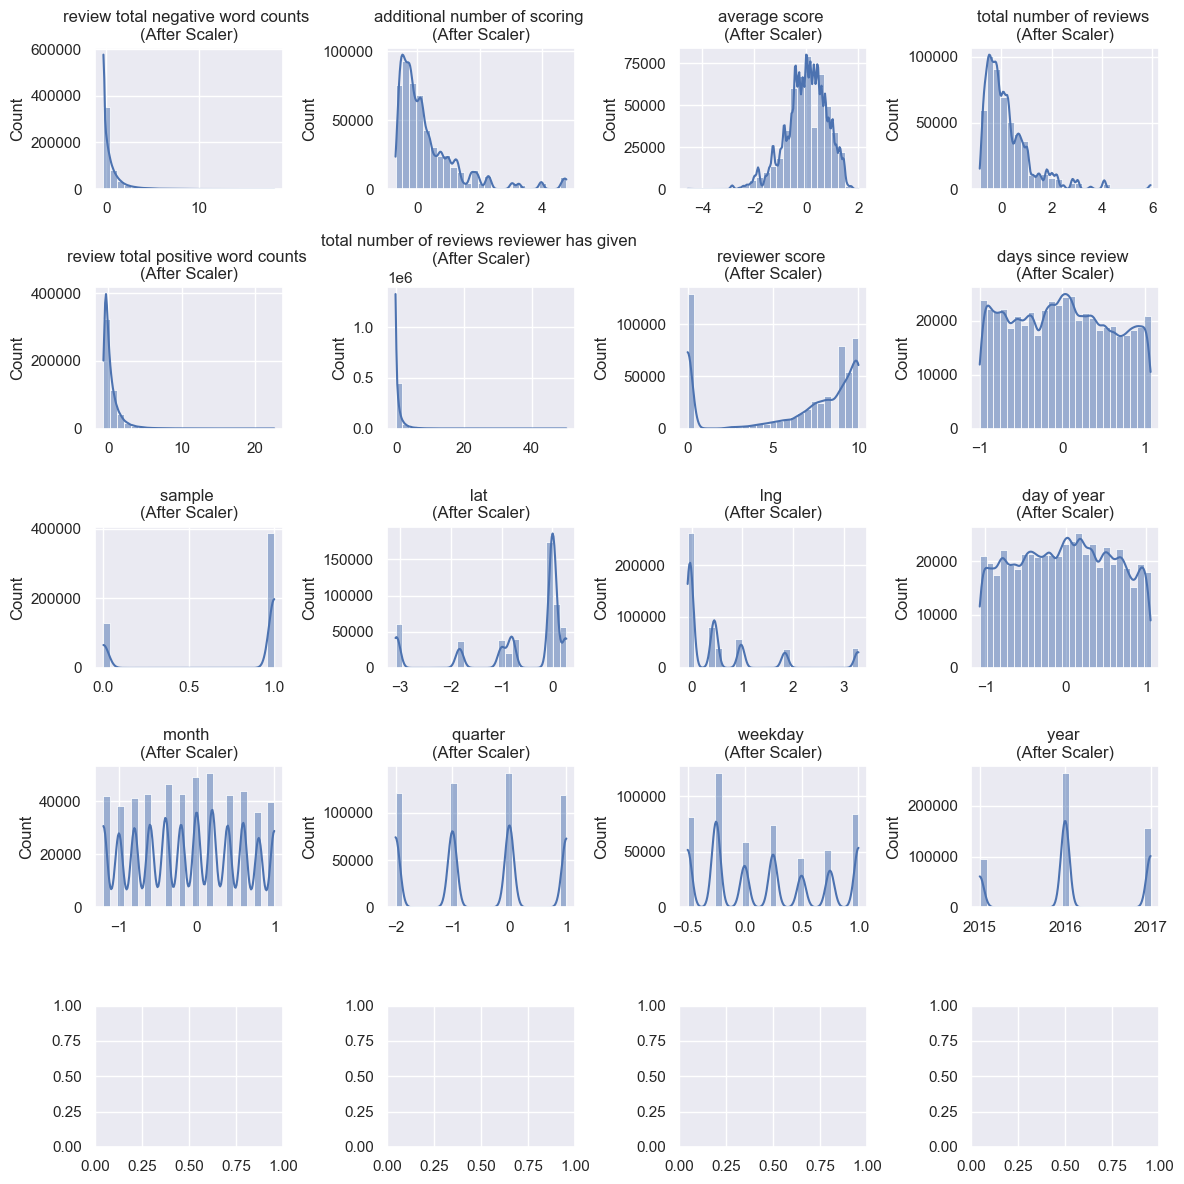

In [ ]:
# Отображаем распределение модифицированных признаков в виде гистограмм
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

col_list = num_data_hotel.columns.tolist()

for i, j in enumerate(col_list):
    if i <= 3:
        hist = sns.histplot(data=num_data_hotel[j], legend=False, kde=True, 
                         bins=25, ax=ax[0, i])
    
        hist.set(title=f'{j} \n(After Scaler)'.replace('_', ' '), xlabel='')
        
    elif i <= 7:
        hist = sns.histplot(data=num_data_hotel[j], legend=False, kde=True, 
                         bins=25, ax=ax[1, i-4])
    
        hist.set(title=f'{j} \n(After Scaler)'.replace('_', ' '), xlabel='')
     
    elif i <= 11:
        hist = sns.histplot(data=num_data_hotel[j], legend=False, kde=True, 
                         bins=25, ax=ax[2, i-8])
    
        hist.set(title=f'{j} \n(After Scaler)'.replace('_', ' '), xlabel='')   
        
    else:
        hist = sns.histplot(data=num_data_hotel[j], legend=False, kde=True, 
                         bins=25, ax=ax[3, i-12])
    
        hist.set(title=f'{j} \n(After Scaler)'.replace('_', ' '), xlabel='') 

fig.tight_layout()
fig.show()

In [60]:
year_dummie = pd.get_dummies(num_data_hotel['year'], prefix='year', dtype=int)
year_dummie

,year_2015,year_2016,year_2017
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
4,0,1,0
...,...,...,...
515733,0,1,0
515734,0,1,0
515735,0,0,1
515736,1,0,0


# Оцениваем корреляцию признаков

In [61]:
# Обединяем  преобразованные признаки в единый датафрейм
hotels_data_transformed = pd.concat([num_data_hotel, obj_data_hotel_final, year_dummie], axis=1)

hotels_data_transformed

,review_total_negative_word_counts,additional_number_of_scoring,average_score,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,sample,lat,...,couple,mobile_submit,reviewer_nationality_2,United Kingdom,Spain,Austria,room_type_5,year_2015,year_2016,year_2017
0,-0.272727,0.488798,0.000000,-0.057096,-0.411765,0.571429,10.0,0.505682,1,0.002396,...,1,1,0,1,0,0,0,0,1,0
1,-0.227273,-0.085540,-0.142857,-0.315253,-0.529412,1.571429,6.3,-0.426136,1,0.006368,...,1,0,0,1,0,0,0,0,0,1
2,-0.136364,-0.629328,0.714286,-0.704731,-0.647059,1.571429,7.5,-0.181818,1,-0.803930,...,0,1,0,0,0,0,0,0,1,0
3,-0.318182,-0.625255,-1.285714,-0.622757,0.000000,0.714286,10.0,0.931818,1,-0.790811,...,0,0,0,0,0,0,0,1,0,0
4,-0.227273,1.167006,0.142857,2.223491,0.529412,1.000000,9.6,0.463068,1,0.268204,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,-0.318182,-0.586558,-0.428571,-0.469005,-0.411765,1.571429,0.0,0.551136,0,-1.816313,...,1,0,1,0,0,0,0,0,1,0
515734,-0.318182,-0.600815,-0.857143,-0.657015,0.764706,-0.285714,0.0,0.164773,0,-3.065327,...,1,1,0,0,1,0,0,0,1,0
515735,1.000000,-0.164969,-0.571429,0.541191,0.705882,-0.285714,0.0,-0.923295,0,-1.001340,...,0,0,1,0,0,1,0,0,0,1
515736,-0.318182,-0.370672,0.857143,-0.440865,0.529412,0.571429,0.0,0.661932,0,-1.826676,...,0,1,1,0,0,0,0,1,0,0


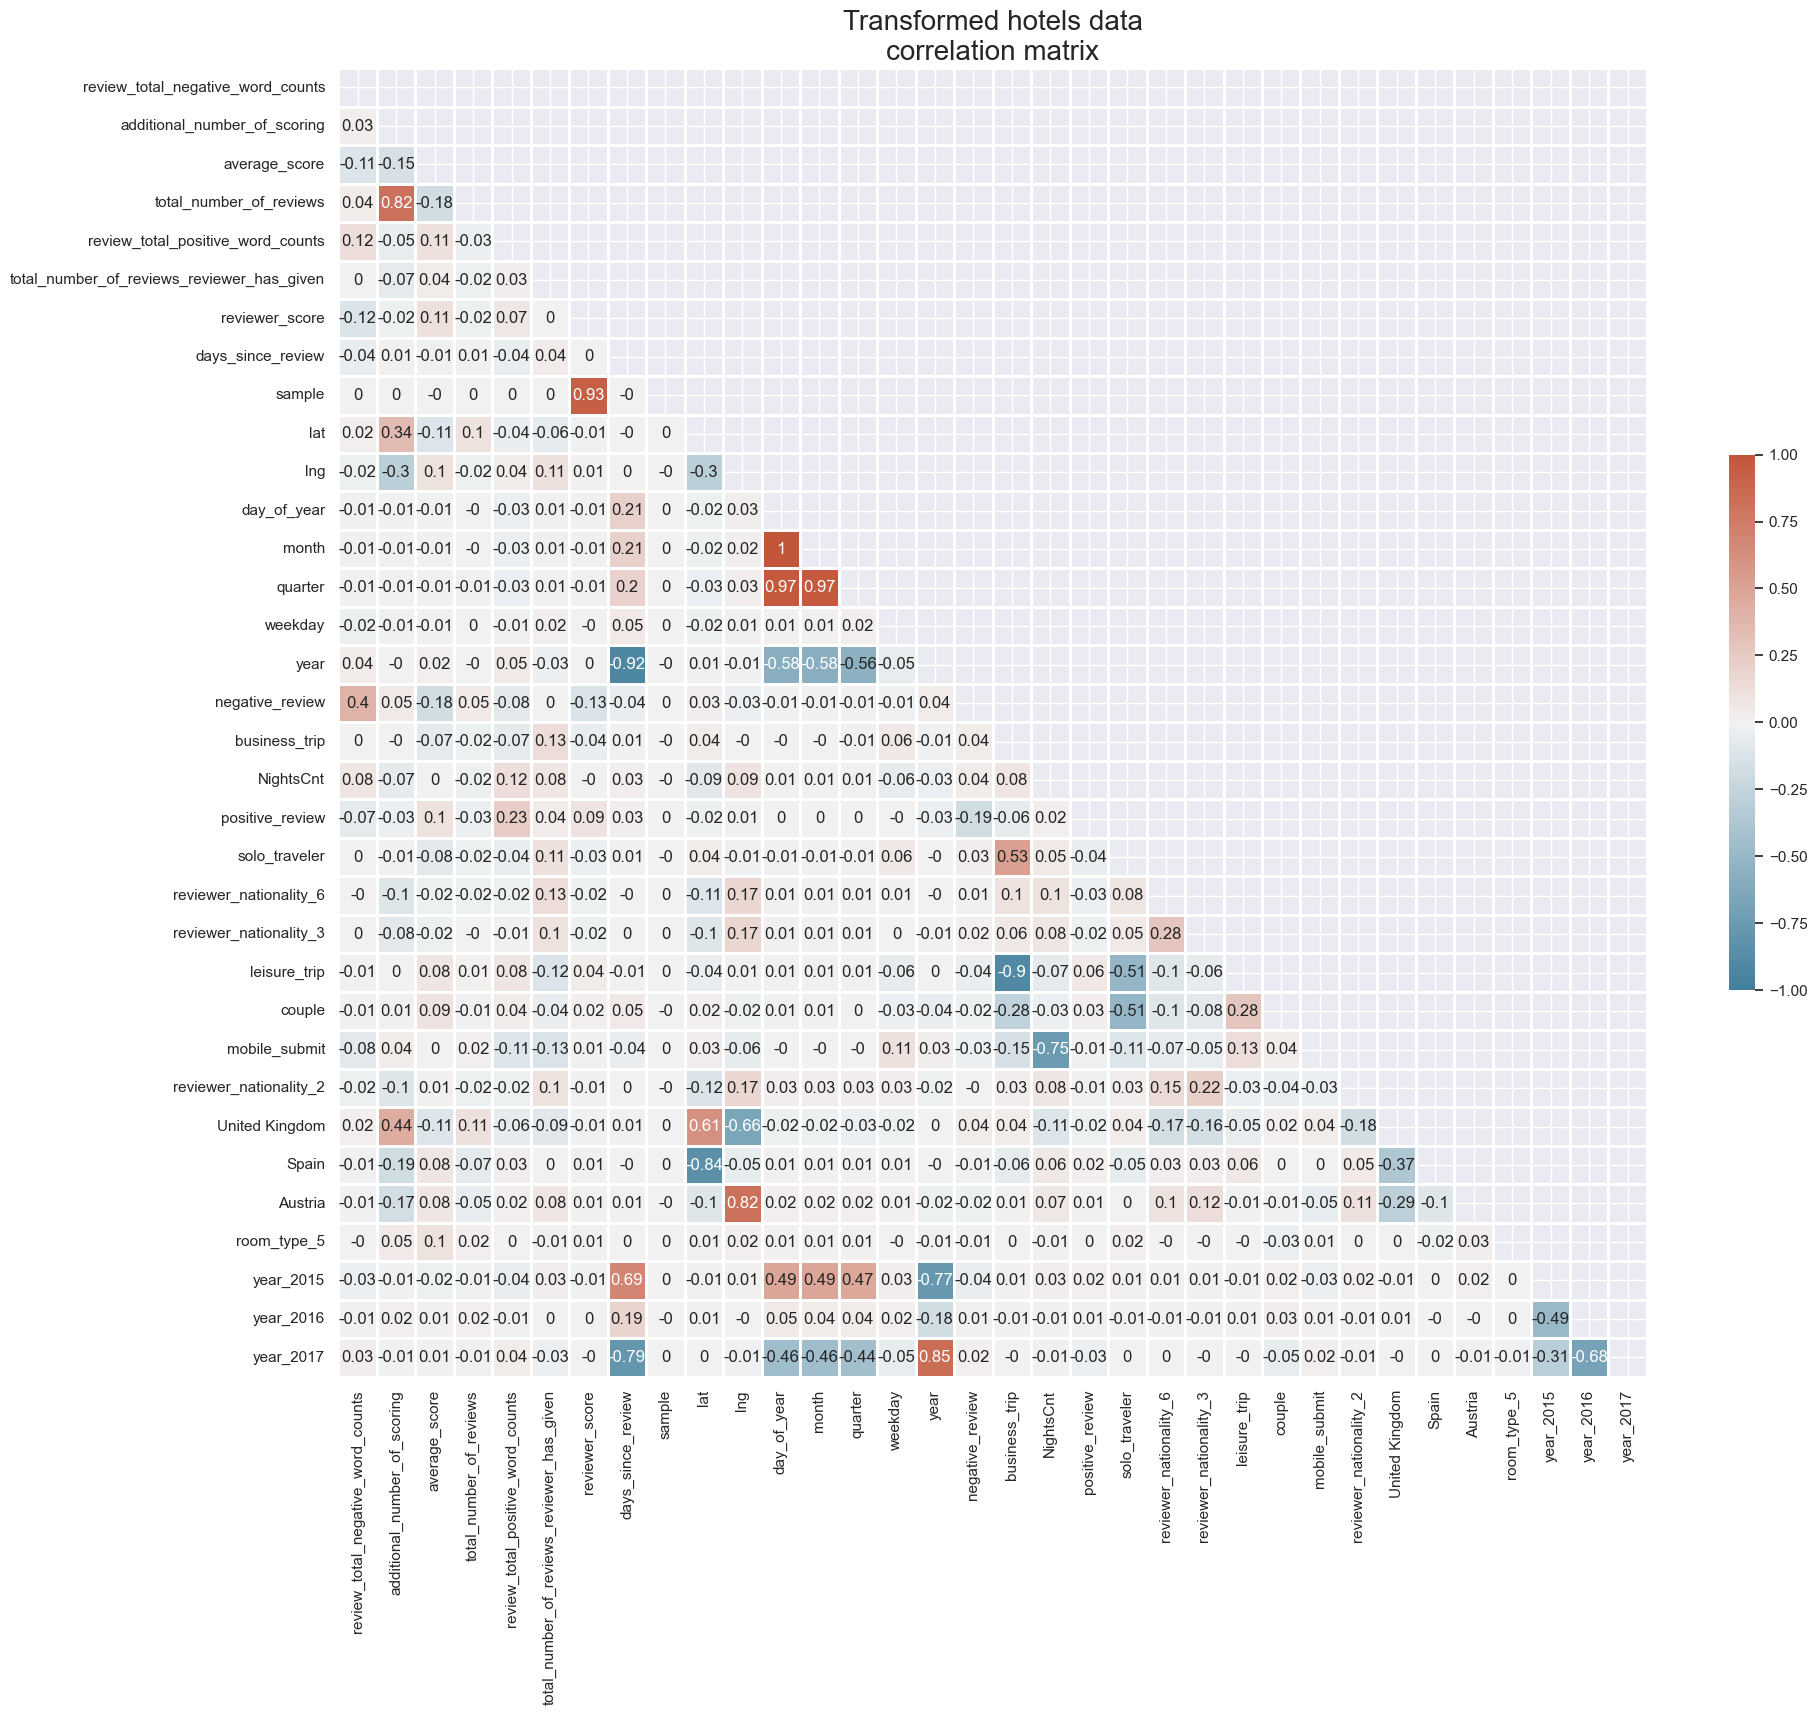

In [62]:
# Генерируем корреляционную матрицу
corr_mat = hotels_data_transformed.corr(numeric_only=True)
corr_mat

# Создаем маску которая позволит убрать верхний треугольник
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Генерируем тепловую карту корреляций
fig, ax = plt.subplots()

fig.set_size_inches(20, 20)

cmap=sns.diverging_palette(230,  20, as_cmap=True)

corr_heatmap = sns.heatmap(data=round(corr_mat, 2), mask=mask, 
            cmap=cmap, square=True, linewidths=0.75, 
            vmin=-1, vmax=1, annot=True, cbar_kws={'shrink': 0.3})

corr_heatmap.set_title('Transformed hotels data\ncorrelation matrix', 
                      fontdict={'size':20})
fig.tight_layout()
################################################################################




In [63]:
# Определяем пары с уровнем коэффициента корреляциии -0.7 или ниже
high_neg_corr = corr_mat.min().sort_values()
high_neg_corr = high_neg_corr[high_neg_corr <= -0.7]
display(high_neg_corr)

# business_trip = leisure_trip
###############################################################################


# Определяем пары с уровнем коэффициента корреляциии 0.7 или выше
corr_mat = corr_mat[corr_mat != 1]
high_pos_corr = corr_mat.max()
high_pos_corr = high_pos_corr[high_pos_corr >= 0.7].sort_values()
display(high_pos_corr)

# additional_number_of_scoring = total_number_of_reviews
###############################################################################



year                -0.917266
days_since_review   -0.917266
business_trip       -0.904034
leisure_trip        -0.904034
lat                 -0.842859
Spain               -0.842859
year_2017           -0.791351
year_2015           -0.772194
NightsCnt           -0.749118
mobile_submit       -0.749118
dtype: float64

lng                             0.820364
Austria                         0.820364
additional_number_of_scoring    0.824884
total_number_of_reviews         0.824884
year                            0.845223
year_2017                       0.845223
reviewer_score                  0.931753
sample                          0.931753
quarter                         0.969874
day_of_year                     0.996227
month                           0.996227
dtype: float64

In [64]:
# Удаляем одну из сильно скоррелированных пар признаков (признак sample игнорируем)
hotels_data_final = hotels_data_transformed.drop(['business_trip', 
                                              'Spain',
                                              'year_2017',
                                              'NightsCnt',
                                              'Austria',
                                              'additional_number_of_scoring',                                             
                                              'day_of_year', 'month'], axis=1)
                                               
hotels_data_final

,review_total_negative_word_counts,average_score,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,sample,lat,lng,...,reviewer_nationality_6,reviewer_nationality_3,leisure_trip,couple,mobile_submit,reviewer_nationality_2,United Kingdom,room_type_5,year_2015,year_2016
0,-0.272727,0.000000,-0.057096,-0.411765,0.571429,10.0,0.505682,1,0.002396,-0.032813,...,0,0,1,1,1,0,1,0,0,1
1,-0.227273,-0.142857,-0.315253,-0.529412,1.571429,6.3,-0.426136,1,0.006368,-0.028685,...,0,0,0,1,0,0,1,0,0,0
2,-0.136364,0.714286,-0.704731,-0.647059,1.571429,7.5,-0.181818,1,-0.803930,0.462582,...,1,0,1,0,1,0,0,0,0,1
3,-0.318182,-1.285714,-0.622757,0.000000,0.714286,10.0,0.931818,1,-0.790811,0.476404,...,0,0,1,0,0,0,0,0,1,0
4,-0.227273,0.142857,2.223491,0.529412,1.000000,9.6,0.463068,1,0.268204,0.968430,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,-0.318182,-0.428571,-0.469005,-0.411765,1.571429,0.0,0.551136,0,-1.816313,1.846100,...,1,1,0,1,0,1,0,0,0,1
515734,-0.318182,-0.857143,-0.657015,0.764706,-0.285714,0.0,0.164773,0,-3.065327,0.433095,...,0,0,1,1,1,0,0,0,0,1
515735,1.000000,-0.571429,0.541191,0.705882,-0.285714,0.0,-0.923295,0,-1.001340,3.279550,...,1,0,0,0,0,1,0,0,0,0
515736,-0.318182,0.857143,-0.440865,0.529412,0.571429,0.0,0.661932,0,-1.826676,1.843200,...,0,0,1,0,1,1,0,0,1,0


# Тестирование

In [65]:
from sklearn.model_selection import train_test_split  
# разделим обратно датасет на тренировочный и тестовый
train_data = hotels_data_final.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_data_final.query('sample == 0').drop(['sample'], axis=1)



In [66]:
y = train_data.reviewer_score.values # таргет
X = train_data.drop(['reviewer_score'], axis=1)

# выделим 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# предсказываем рейтинг в тестовов датасете и записываем в переменную y_pred
y_pred = model.predict(X_test)

# сравниваем предсказанные значения с реальными, метрика - MAPE
print(f'MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred):.4f}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s


MAPE: 0.1336


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.1s finished


<Axes: >

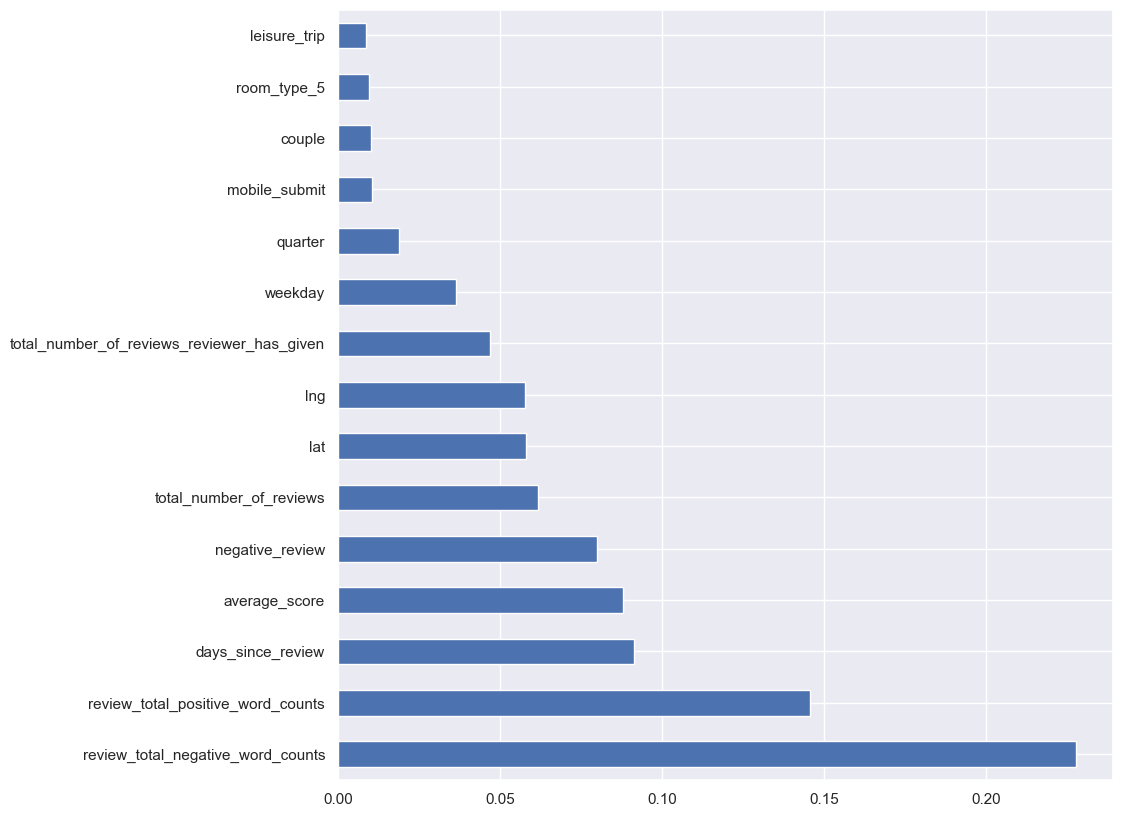

In [69]:
# Позволяет вывести топ самых влияющих признаков
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Заключение

1. После преобразования признаков уровень метрики MAPE составил 0.133 <br>

2. Ключевыми признаками, определяющими отзыв рецензента являются:
* **'review_total_negative_word_counts'** (общее количество слов в отрицательном отзыв) <br>
* **'review_total_positive_word_counts'**(общее количество слов в положительном отзыве) <br>
* **'days_since_review'** (количество дней между датой проверки отзыва и датой очистки) <br>
* **'average_score'** (средний балл отеля, рассчитанный на основе последнего комментария за последний год) <br>
* **'negative_review'** (отрицательный отзыв, который рецензент дал отелю)
3. Для улучшения метрики MAPE было предложено преобразовать слова в векторы с использованием Doc2Vec из библиотеки gensim.  

## Хотелось бы выразить отдельную благодарность Сергею Добдину за качественный и полезный фидбек